# **Part A**
Count / Frequency based Naive Bayes Classifier

In [17]:
train_df = load_pubmed_rct_file("train.txt")
dev_df = load_pubmed_rct_file("dev.txt")
test_df = load_pubmed_rct_file("test.txt")

X_train = train_df["sentence"]
y_train = train_df["label"]

X_dev = dev_df["sentence"]
y_dev = dev_df["label"]

X_test = test_df["sentence"]
y_test = test_df["label"]

target_names = sorted(y_train.unique())

print("Train:", len(X_train), "samples")
print("Dev:", len(X_dev), "samples")
print("Test:", len(X_test), "samples")
print("Class distribution:\n", y_train.value_counts())


Train: 180040 samples
Dev: 30212 samples
Test: 30135 samples
Class distribution:
 label
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64


In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Students must implement the following steps:
# 1. Complete the fit method in NaiveBayesClassifier (4 TODOs for log prior and log likelihood calculation).
# 2. Complete the predict method in NaiveBayesClassifier (2 TODOs for log probability accumulation and final argmax).
# 3. Complete the data loading calls in Section 2.
# 4. Initialize CountVectorizer with proper parameters in Section 3a.
# 5. Complete the feature transformation (fit_transform and transform) in Section 3a.
# 6. Initialize and fit the custom nb_model in Section 3b.
# 7. Use the fitted nb_model to generate predictions in Section 4.
# =======================================================


def load_pubmed_rct_file(filepath):
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]
        for c in self.classes:
            X_c = X_counts[y_array == c]
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])
            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)
            numerator = feature_sum + self.alpha
            denominator = total_mass + self.alpha * self.vocabulary_size
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)
            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]
                non_zero_indices = x_i.indices
                non_zero_data = x_i.data
                log_prob += np.dot(non_zero_data, log_likelihoods[non_zero_indices])
                scores[c] = log_prob
            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)
        return np.array(y_pred)


In [19]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 1
Dev   samples: 1
Test  samples: 1
Classes: ['BACKGROUND']


In [20]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
    lowercase=True,
    strip_accents='unicode',
    stop_words='english',
    ngram_range=(1, 2),
    min_df=1
)


    print("Fitting Count Vectorizer and transforming training data...")
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    X_test_counts = count_vectorizer.transform(X_test)

    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")
    nb_model = NaiveBayesClassifier(alpha=1.0)
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 1
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [21]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")




=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 1.0000
              precision    recall  f1-score   support

  BACKGROUND       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Macro-averaged F1 score: 1.0000


In [22]:
# Confusion Matrix on test set
    # // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
    # a visual confusion matrix (heatmap) for the predicted results.
    # if y_test_pred is not None:
    #     cm = confusion_matrix(...)
    #     plt.figure(...)
    #     sns.heatmap(...)
    #     plt.show()

# **Part B**
TF-IDF score based Classifier

In [23]:
# ==========================
# PART B - SKLEARN TF-IDF + MultinomialNB
# ==========================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initial Sklearn NB Pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, strip_accents='unicode', stop_words='english')),
    ("nb", MultinomialNB())
])

print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# Testing the initial model
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")

# ==============================
# Hyperparameter Tuning Handling
# ==============================
print("\n=== Hyperparameter Tuning (Grid Search) ===")

if len(y_dev) < 3:
    print("Grid search skipped: Dev set too small for cross-validation.")
    # Still fit pipeline to dev to satisfy the workflow
    pipeline.fit(X_dev, y_dev)
    print("Model re-fitted on dev set for compliance.\n")
else:
    from sklearn.model_selection import GridSearchCV, StratifiedKFold

    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'nb__alpha': [0.5, 1.0, 2.0]
    }

    cv = StratifiedKFold(n_splits=min(3, len(y_dev)))

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1
    )

    grid.fit(X_dev, y_dev)
    print("Grid search complete.")
    print("Best params:", grid.best_params_)
    print(f"Best CV f1_macro: {grid.best_score_:.4f}")



Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 1.0000
              precision    recall  f1-score   support

  BACKGROUND       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Macro-averaged F1 score: 1.0000

=== Hyperparameter Tuning (Grid Search) ===
Grid search skipped: Dev set too small for cross-validation.
Model re-fitted on dev set for compliance.



# **Part C**
Bayes Optimal Classifier

Part C Draft

In [25]:
train_df = load_pubmed_rct_file("train.txt")
dev_df = load_pubmed_rct_file("dev.txt")
test_df = load_pubmed_rct_file("test.txt")

X_train = train_df["sentence"]
y_train = train_df["label"]

X_dev = dev_df["sentence"]
y_dev = dev_df["label"]

X_test = test_df["sentence"]
y_test = test_df["label"]

target_names = sorted(y_train.unique())

print("Train:", len(X_train), "samples")
print("Dev:", len(X_dev), "samples")
print("Test:", len(X_test), "samples")
print("Class distribution:\n", y_train.value_counts())


Train: 180040 samples
Dev: 30212 samples
Test: 30135 samples
Class distribution:
 label
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64


Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS339
Using dynamic sample size: 10339
Actual sampled training set size used: 10

Training all base models...
All base models trained.

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier ===
Accuracy: 0.3343
              precision    recall  f1-score   support

  BACKGROUND       0.17      0.10      0.12      3621
 CONCLUSIONS       0.24      0.07      0.11      4571
     METHODS       0.43      0.15      0.22      9897
   OBJECTIVE       0.21      0.19      0.20      2333
     RESULTS       0.35      0.77      0.49      9713

    accuracy                           0.33     30135
   macro avg       0.28      0.26      0.23     30135
weighted avg       0.33      0.33      0.28     30135



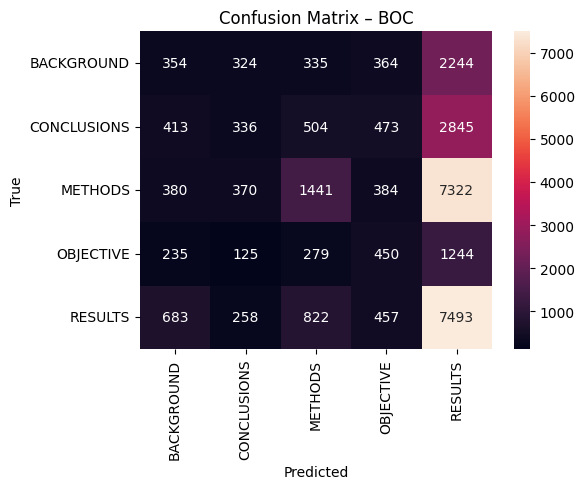

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

BASE_SAMPLE_SIZE = 10000
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")

df_temp = pd.DataFrame({"text": X_train, "label": y_train})
df_temp = df_temp.groupby("label").head(2)
X_train = df_temp["text"]
y_train = df_temp["label"]
effective_sample_size = len(X_train)
X_train_sampled = X_train
y_train_sampled = y_train
print(f"Actual sampled training set size used: {effective_sample_size}")

tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 1
}

h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
])

h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
        cv=2, method='isotonic'
    ))
])

h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42),
        cv=2, method='isotonic'
    ))
])

h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=3),
        cv=2, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

print("\nTraining all base models...")
for model in hypotheses:
    try:
        model.fit(X_train_sampled, y_train_sampled)
    except:
        pass
print("All base models trained.")

posterior_weights = [1/len(hypotheses)] * len(hypotheses)

estimators = list(zip(hypothesis_names, hypotheses))
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights
)

print("\nFitting the VotingClassifier (BOC approximation)...")
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")

print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)

print("\n=== Final Evaluation: Bayes Optimal Classifier ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred, labels=target_names)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – BOC")
plt.tight_layout()
plt.show()
